# Training from scratch on Imagewoof with the efficientnet_pytorch repo

https://github.com/lukemelas/EfficientNet-PyTorch

In [24]:
!pip install efficientnet_pytorch

You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *
from efficientnet_pytorch import EfficientNet
import sys

torch.backends.cudnn.benchmark = True
fastprogress.MAX_COLS = 80

def get_data(size, woof, bs, workers=None):
    if   size<=128: path = URLs.IMAGEWOOF_160 if woof else URLs.IMAGENETTE_160
    elif size<=224: path = URLs.IMAGEWOOF_320 if woof else URLs.IMAGENETTE_320
    else          : path = URLs.IMAGEWOOF     if woof else URLs.IMAGENETTE
    path = untar_data(path)

    n_gpus = num_distrib() or 1
    if workers is None: workers = min(8, num_cpus()//n_gpus)

    return (ImageList.from_folder(path).split_by_folder(valid='val')
            .label_from_folder().transform(([flip_lr(p=0.5)], []), size=size)
            .databunch(bs=bs, num_workers=workers)
            .presize(size, scale=(0.35,1))
            .normalize(imagenet_stats))



In [2]:
data = get_data(240,1,32)

In [16]:
opt_func = partial(optim.Adam, betas=(0.9,0.99), eps=1e-6)

In [17]:
m = EfficientNet.from_name('efficientnet-b1')

In [18]:
m._fc = nn.Linear(m._fc.in_features, out_features=10, bias=True)
nn.init.kaiming_normal_(m._fc.weight)

Parameter containing:
tensor([[-0.0208, -0.0298, -0.0153,  ..., -0.0610, -0.0226, -0.0348],
        [-0.0185,  0.0455,  0.0367,  ..., -0.0122, -0.0035, -0.0245],
        [ 0.0312,  0.0296,  0.0008,  ..., -0.0234, -0.0463,  0.1029],
        ...,
        [-0.0094,  0.0356, -0.0382,  ..., -0.0109,  0.0578, -0.0075],
        [-0.0609, -0.0240, -0.0185,  ..., -0.0215,  0.0371, -0.0239],
        [ 0.0259,  0.0139,  0.0056,  ...,  0.0548, -0.0466,  0.0260]],
       requires_grad=True)

In [19]:

learn = (Learner(data, m, wd=1e-5, opt_func=opt_func,
         metrics=[accuracy,top_k_accuracy],
         bn_wd=False, true_wd=True,
         loss_func = LabelSmoothingCrossEntropy())
        )
    

In [20]:
mixup = 0 
if mixup: learn = learn.mixup(alpha=mixup)
learn = learn.to_fp16(dynamic=True)
    
        


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


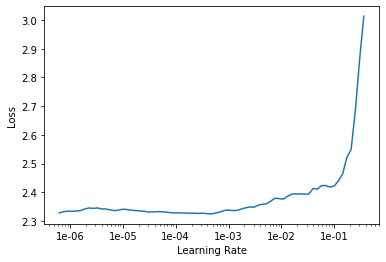

In [8]:
learn.lr_find()
learn.recorder.plot()

In [9]:
learn.fit_one_cycle(5, 1e-4, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.243000,2.305701,0.100000,0.500000,01:57
1,2.116734,2.152997,0.248000,0.742000,01:56
2,2.029070,2.006547,0.310000,0.790000,01:57
3,1.957809,1.923689,0.360000,0.812000,01:56
4,1.930043,1.921397,0.368000,0.794000,01:55


In [15]:
# restarted from scratch
learn.fit_one_cycle(5, 1e-3, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.115052,2.362708,0.100000,0.500000,01:56
1,1.955134,6.912424,0.176000,0.702000,01:58
2,1.787405,1.831567,0.448000,0.894000,01:56
3,1.657472,1.548386,0.526000,0.936000,01:55
4,1.559327,1.447817,0.578000,0.946000,01:55


In [21]:
# restarted from scratch
learn.fit_one_cycle(5, 5e-3, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.166082,4.765602,0.100000,0.502000,01:55
1,2.078946,5.777719,0.158000,0.616000,01:54
2,1.976010,3.223228,0.214000,0.688000,01:56
3,1.846923,1.905836,0.310000,0.878000,01:58
4,1.808402,1.717624,0.444000,0.904000,01:56
